In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import sys, os, glob, re, time
import numpy as np
import csv
from collections import Counter
import pickle
import gc
import datetime
import pandas as pd
# import numpy as np
# import networkx as nx
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
from dateutil import parser
# import keras
# import time
# from keras.models import Sequential
# from keras.layers import Activation, Dense, Flatten
# from keras.layers import LSTM
# from keras.layers import Dropout
import psycopg2
from sshtunnel import SSHTunnelForwarder
import community
def shrinkData(df):
    df_int = df.select_dtypes(include=['int'])
    df_int = df_int.apply(pd.to_numeric,downcast='unsigned')
    df_float = df.select_dtypes(include=['float'])
    df_float = df_float.apply(pd.to_numeric,downcast='float')
    df['date'] = pd.to_datetime(df['date'])
    cols = df.columns[df.dtypes.eq(object)]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=0)
    return df

def query_to_DataFrame(sqlString):
    with SSHTunnelForwarder(
        ('67.240.57.228', 22),
        #ssh_private_key="</path/to/private/ssh/key>",
        ### in my case, I used a password instead of a private key
        ssh_username="root",
        ssh_password="b3110cFr13nd", 
        remote_bind_address=('localhost', 5432)) as server:

        server.start()
        print("server connected")

        params = {
         'database': 'Prices',
         'user': 'analyst',
         'password': 'st4rg4z3r',
         'host': 'localhost',
         'port': server.local_bind_port
         }

        conn = psycopg2.connect(**params)
        curs = conn.cursor()
        print("database connected")
        # Get a database cursor
        cur = conn.cursor()

        # Execute SQL
        cur.execute(sqlString)
    #     colnames = [desc.name for desc in curs.description] 
#         print("description is :", cur.description)
        # Get the result
        result = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]
        frame = shrinkData(pd.DataFrame(result, columns=colnames))
    #     print(result)

        # Close connections
        conn.close()

        # Stop the tunnel
        server.stop()
        return frame
    
def merge_data(a, b, from_date='2018-01-01'):
    """
    a: first DataFrame
    b: second DataFrame
    from_date: includes the data from the provided date and drops the any data before that date.
    returns merged data as Pandas DataFrame
    """
    merged_data = pd.merge(a, b, on=['Date'])
    merged_data = merged_data[merged_data['Date'] >= from_date]
    print("Merged")
    return merged_data
# reads tsv edge list where each line is in the format "leftnode rightnode"
# assumes file header contains 'sym' for undirected graph and 'asym' for directed graphs
def convert_tsv_to_graphml(filename):
    m = re.search("(.*)\.tsv", filename)
    name = m.group(1)
    file = open(filename, 'rb')
    header = file.readline()
    print(header)
    if b"asym" in header:
        graph_type = nx.DiGraph()
    else:
        graph_type = nx.Graph()
    lines = [line for line in file if not line.startswith(b"%")]
    print(lines[0], lines[1],"\n")
    g = nx.read_edgelist(lines, create_using=graph_type)
    nx.write_graphml(g, name+".graphml")  
    print(filename)
    return g

def distribution(counts, attribute):
    vals, cnt = zip(*counts.items())
    
    # get rid of all negative values by bumping everything up
    if (np.array(vals) < 0).any():
        print(attribute + " had negative values but is shifted up by {} now".format(-min(vals) + 1))
        vals = np.array(vals) - min(vals) + 1
        
    if 0 in np.array(vals):
        vals = np.array(vals) + 1   # account for possible 0 values for log plot
        print(attribute + " has been shifted up by 1")
        
    fig, ax = plt.subplots()
    plt.scatter(vals, cnt, color='b')
    
    plt.title(attribute + " Plot")
    plt.ylabel("Count")
    plt.xlabel(attribute)
    plt.yscale('log')
    # clustering coefficient only has log plot, not log log
    if attribute == "Clustering Coefficient":
        plt.xscale('linear')
        log_vals = np.log10(vals)
    else:
        plt.xscale('log')
        log_vals = np.log10(vals)
    
    #deg = np.log10(np.array(deg))
    #cnt = np.log10(np.array(cnt))
    vals = np.array(vals)
    cnt = np.array(cnt)
    log_vals = np.log10(vals)
    log_cnt = np.log10(cnt)
    
    m, b = np.polyfit(log_vals, log_cnt, 1)
    y_fit = np.power(10, m*log_vals + b)
    #plt.plot(deg, cnt, '.')
    plt.plot(vals, y_fit , '-')
    
# This will read in the correlation TSV file and create the graphML file to disk
def make_currency_graph(filename, name):
    corr = np.genfromtxt(fname=filename, delimiter='\t',dtype=float, names=True)    # fname="correlations.tsv"
    corrGraph = nx.Graph()
    names = corr.dtype.names
    
    for i in range(len(corr)):
        l_node = names[i]
        l_type = l_node.split("_")[-1]
        l_name = l_node.split("_")[0]
        
        for j in range(i + 1, len(corr)):
            r_node = names[j]
            
            if i == 0:
                r_type = r_node.split("_")[-1]
                r_name = r_node.split("_")[0]
                corrGraph.add_node(l_node, position=l_type, name = l_name)
                corrGraph.add_node(r_node, position=r_type, name = r_name)
                
            corrGraph.add_edge(l_node, r_node, weight = float(corr[i][j]))
    
    corrGraph.name = name
    corrGraph = nx.maximum_spanning_tree(corrGraph)
    nx.write_graphml(corrGraph, corrGraph.name + ".graphml")

    return corrGraph

def createGraphFiles(filename, name):
    graphs = []
    g = make_currency_graph(filename, name)
    print("Creating graphml file for", g.name)
    print("Graph name is", g.name)

    # Create or retrieve Erdos-Renyi random graph
    if not os.path.exists(g.name + "_ER.graphml"):
        print("Creating ER graph for " + g.name + " from scratch")
        k = 2 * g.number_of_edges() / g.number_of_nodes()   # average degree

 
        print("For currencies, use weighted degree for ER")
        edges_dict = g.edges()
        k = sum([edges_dict[edge]["weight"] for edge in edges_dict]) * 2 / g.number_of_nodes()

        p = k / (g.number_of_nodes() - 1)                  # probability = avg deg / # of possible neighbors (n-1)
        g_ER = nx.generators.erdos_renyi_graph(g.number_of_nodes(), p)
        nx.write_graphml(g_ER, g.name+"_ER.graphml")
    else:
        print("Reading in the ER graphml file for " + g.name)
        g_ER = nx.read_graphml(g.name+"_ER.graphml")
    g_ER.name = g.name + "_ER"

    # Create or retrieve Barabasi-Albert scale-free network
    if not os.path.exists(g.name + "_BA.graphml"):
        print("Creating BA graph for " + g.name + " from scratch")
        m = 1
        n = g.number_of_nodes()
        g_BA = nx.generators.barabasi_albert_graph(n, m)
        old_dist = abs(g.number_of_edges() - g_BA.number_of_edges())

        # increment m until it generates the BA graph closest to real graph also make sure m never equals n
        while g_BA.number_of_edges() < g.number_of_edges() and m + 1 < n:
            m += 1
            old_dist = abs(g.number_of_edges() - g_BA.number_of_edges())
            g_BA = nx.generators.barabasi_albert_graph(n, m)

        # See how close our graph is to the original and decrement m by 1 if we've gone too far    
        dist = abs(g_BA.number_of_edges() - g.number_of_edges())
        if old_dist < dist:
            g_BA = nx.generators.barabasi_albert_graph(n, m - 1)
            print("Use previous m value:", m - 1)
        else:
            print("Use current m value:", m)

        nx.write_graphml(g_BA, g.name + "_BA.graphml")
    else:
        print("Reading in the BA graphml file for " + g.name)
        g_BA = nx.read_graphml(g.name+"_BA.graphml")
    g_BA.name = g.name + "_BA"    

    graphs += [g, g_ER, g_BA]
    return graphs

def analyzeGraphs(graphs):
    # Now loop through all of our graphs
    i = 1
    for g in graphs:

        graph_name = g.name

        # if we haven't generated the CSV files yet, cut the program off and prompt the user to do so
        if not os.path.exists(graph_name + ".csv"):
            print("We are missing the CSV file of statistics '{}'".format(graph_name + ".csv"))
            print("Now run Gephi statistics on the created GraphML files and export as CSV, then rerun this program")
            continue

        print("\nReading the graph metrics from '" + graph_name + "'.csv")

        statFilCSV = open(graph_name + ".csv", 'r')
        headFile = open(graph_name + ".csv", 'r')
        header = next(csv.reader(headFile))
        headFile.close()

        reader = csv.DictReader(statFilCSV)
        network_stats = {attribute: [] for attribute in header}
        counters = {}

        # Get raw network statistics from CSV Gephi output
        for row in reader:
            Id, label, timeset, eccentricity, closnesscentrality, harmonicclosnesscentrality, betweenesscentrality, componentnumber, degree, clustering, triangles, eigencentrality, weightedDegree \
            = row["Id"], row["Label"],	row["timeset"],	int(row["Eccentricity"]),	float(row["closnesscentrality"]),	float(row["harmonicclosnesscentrality"]),	float(row["betweenesscentrality"]),	int(row["componentnumber"]),	int(row["Degree"]),	float(row["clustering"]),	int(row["triangles"]),	float(row["eigencentrality"]),	float(row["Weighted Degree"])
            network_stats["clustering"].append(clustering)
            network_stats["betweenesscentrality"].append(betweenesscentrality)
            network_stats["Degree"].append(degree)
            network_stats["closnesscentrality"].append(closnesscentrality)
            network_stats["componentnumber"].append(componentnumber)
            network_stats["Weighted Degree"].append(weightedDegree)

        # Get distribution of network statistics
        counters["Degree"] = Counter(sorted(network_stats["Degree"]))
        counters["clustering"] = Counter(sorted(network_stats["clustering"]))
        counters["betweenesscentrality"] = Counter(sorted(network_stats["betweenesscentrality"]))
        counters["closnesscentrality"] = Counter(sorted(network_stats["closnesscentrality"]))
        counters["componentnumber"] = Counter(sorted(network_stats["componentnumber"]))
        counters["Weighted Degree"] = Counter(sorted(network_stats["Weighted Degree"]))

        components = nx.connected_component_subgraphs(g)
        components = sorted(components, key=len, reverse=True)
        network_stats["componentsize"] = [len(comp) for comp in components]
        cc = Counter(network_stats["componentsize"])
        gc = components[0]
        print("Size of largest connected component:", len(gc))
        counters["componentsize"] = cc

        plt.figure(i)
        i += 1

        distribution(counters["Degree"], "Degree")
        plt.suptitle(graph_name)
        if not os.path.exists(graph_name+"-Degree.png"):
            plt.savefig(graph_name+"-Degree.png")
            print("Saving {}-Degree.png".format(graph_name))

        if "currencyCorrelations" in graph_name:
            distribution(counters["Weighted Degree"], "Weighted Degree")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-WeightedDegree.png"):
                plt.savefig(graph_name+"-WeightedDegree.png")
                print("Saving {}-WeightedDegree.png".format(graph_name))

        if len(set(network_stats["clustering"])) > 1:
            distribution(counters["clustering"], "Clustering Coefficient")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-ClusteringCoefficient.png"):
                plt.savefig(graph_name+"-ClusteringCoefficient.png")
                print("Saving {}-ClusteringCoefficient.png".format(graph_name))

        if len(set(network_stats["betweenesscentrality"])) > 1:
            distribution(counters["betweenesscentrality"], "Betweeness Centrality")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-BetweenessCentrality.png"):
                plt.savefig(graph_name+"-BetweenessCentrality.png")
                print("Saving {}-BetweenessCentrality.png".format(graph_name))

        if len(set(network_stats["componentnumber"])) > 1:
            distribution(counters["componentsize"], "Connected Components Size")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-ConnectedComponents.png"):
                plt.savefig(graph_name+"-ConnectedComponents.png")
                print("Saving {}-ConnectedComponents.png".format(graph_name))

        plt.show()

        print("\nAverage Values:")
        print("\tAverage Degree: {} weighted, {} unweighted".format(np.mean(network_stats["Degree"]), np.mean(network_stats["Weighted Degree"])))
        print("\tAverage Clustering Coefficient:", np.mean(network_stats["clustering"]))
        print("\tAverage Betweeness Centrality:", np.mean(network_stats["betweenesscentrality"]))
        print("\tAverage Connected Components Size:", np.mean(network_stats["componentsize"]))     # since there's only one connected component, average is # of nodes

        print("\nVariance of Values:")
        print("\tVariance of Degree: {} weighted, {} unweighted".format(np.var(network_stats["Degree"]), np.var(network_stats["Weighted Degree"])))
        print("\tVariance of Clustering Coefficient:", np.var(network_stats["clustering"]))
        print("\tVariance of Betweeness Centrality:", np.var(network_stats["betweenesscentrality"]))
        print("\tVariance of Connected Components Size:", np.var(network_stats["componentsize"]))     # since there's only one connected component, variance is 0


        print("Average Closeness Centrality:", np.mean(network_stats["closnesscentrality"]))
        statFilCSV.close()
        
##### This function draws an induced graph
def draw_induced_graph(G, part):
    g = G
    ind = community.induced_graph(part, g)
    values = [part.get(node) for node in G.nodes()]
    plt.figure(figsize=(25,25))
    nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=200, with_labels=True)

def graphinate(dataframe, name):
    correlations = dataframe.corr()
    correlations.to_csv('correlations.tsv', sep='\t', encoding='utf-8', index=False)
    G = make_currency_graph('correlations.tsv', name)
    return G

def get_market_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
        "/historical-data/?start=20180101&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    market_data = market_data.rename(columns={'Date':'date'})
    market_data = market_data.assign(Date=pd.to_datetime(market_data['date']))
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    if tag:
        market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
    return market_data

def convert_tuple(tuple_partition):
    retDict = dict()
    for node in tuple_partition[0]:
        retDict.update({node:0})
    for node in tuple_partition[1]:
        retDict.update({node:1})
    return retDict

def convert_sort(sorted_list):
    retDict = dict()
    for i in range(0,len(sorted_list)):
        for name in sorted_list[i]:
            retDict.update({name:i})
    return retDict


In [2]:
aggregateQuery = "SELECT * FROM Prices.aggregates WHERE date >= '2018-01-01';"
aggregateframe = query_to_DataFrame(aggregateQuery)

server connected
database connected


In [3]:
indexes = ['GSPC', 'DJI', 'IXIC', 'NYA', 'XAX', 'BUK100P', 'RUT', 'VIX', 'GDAXI', 'FCHI', 'STOXX50E', 'N100', 'BFX', 'HSI', 'AXJO', 'JKSE', 'NZ50', 'KS11', 'TWII', 'GSPTSE', 'BVSP', 'MXX', 'IPSA', 'MERV', 'TA125TA', 'JN0UJO']
instruments = ['COPPERCMDUSD', 'GASCMDUSD', 'LIGHTCMDUSD', 'BRENTCMDUSD', 'DIESELCMDUSD', 'XAUUSD', 'XAGUSD', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDJPY', 'USDCHF', 'USDCAD', 'GBPUSD', 'EURUSD', 'AUDUSD', 'XAGUSD', 'XAUUSD', 'DIESELCMDUSD', 'BRENTCMDUSD', 'LIGHTCMDUSD', 'GASCMDUSD', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'AUDSGD', 'CADCHF', 'CADHKD', 'CADJPY', 'CHFJPY', 'CHFSGD', 'EURAUD', 'EURCAD', 'EURCHF', 'EURCZK', 'EURDKK', 'EURGBP', 'EURHKD', 'EURHUF', 'EURJPY', 'EURNOK', 'EURNZD', 'EURPLN', 'EURRUB', 'EURSEK', 'EURSGD', 'EURTRY', 'GBPAUD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPNZD', 'HKDJPY', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'SGDJPY', 'TRYJPY', 'USDCNH', 'USDCZK', 'USDDKK', 'USDHUF', 'USDILS', 'USDMXN', 'USDNOK', 'USDPLN', 'USDRON', 'USDRUB', 'USDSEK', 'USDSGD', 'USDTHB', 'USDTRY', 'USDZAR', 'ZARJPY']
nameList = ['Dates']
instruments = list(set(instruments))
indexes = list(set(indexes))

In [4]:
### Separate Stocks and Currencies

indexSection = (len(indexes) * 6)+1
StockIndexes = aggregateframe

StockIndexes = StockIndexes.drop(columns=aggregateframe.columns[indexSection:])
StockIndexes.head()

currencies = aggregateframe
currencies = currencies.drop(columns=aggregateframe.columns[1:indexSection])
currencies.head()

date  coppercmdusd_high  coppercmdusd_low  coppercmdusd_avg  \
0 2018-06-12            0.32692            0.3236          0.325211   
1 2018-02-09            0.30870            0.3029          0.306009   
2 2018-02-23            0.32375            0.3193          0.321373   
3 2018-02-28            0.31885            0.3128          0.316278   
4 2018-05-31            0.30950            0.3049          0.307119   

   gascmdusd_high  gascmdusd_low  gascmdusd_avg  lightcmdusd_high  \
0         0.29935        0.29225       0.295303           0.66720   
1         0.27115        0.25829       0.263026           0.60795   
2         0.26380        0.25615       0.260028           0.63755   
3         0.27150        0.26655       0.268763           0.63445   
4         0.29925        0.28940       0.295319           0.68245   

   lightcmdusd_low  lightcmdusd_avg     ...      usdthb_avg  usdtry_high  \
0          0.65555         0.662545     ...        3.209041      4.60237   
1          0.58105         0.598225     ...        3.181486      3.84558   
2          0.62375         0.631505     ...        3.147413      3.79466   
3          0.61395         0.623939     ...        3.145578      3.81686   
4          0.66615         0.674423     ...             NaN          NaN   

   usdtry_low  usdtry_avg  usdzar_high  usdzar_low  usdzar_avg  zarjpy_high  \
0     4.52270    4.556483     13.35087    13.14053   13.210963        0.084   
1     3.80978    3.824769     12.17378    12.00735   12.092882          NaN   
2     3.78082    3.788270     11.69559    11.54302   11.603235          NaN   
3     3.79655    3.804246     11.82159    11.67824   11.754978          NaN   
4         NaN         NaN          NaN         NaN         NaN          NaN   

   zarjpy_low  zarjpy_avg  
0     0.08271    0.083534  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN  

[5 rows x 202 columns]

In [5]:
## Organize Currency Data

a = currencies.columns[currencies.columns.str.endswith('avg')]
a = a.insert(0,'date')
averages = currencies[a]
averages.head()

a = currencies.columns[currencies.columns.str.endswith('high')]
a = a.insert(0,'date')
highCurr = currencies[a]
highCurr.head()

a = currencies.columns[currencies.columns.str.endswith('low')]
a = a.insert(0,'date')
lowCurr = currencies[a]
lowCurr.head()

date  coppercmdusd_low  gascmdusd_low  lightcmdusd_low  \
0 2018-06-12            0.3236        0.29225          0.65555   
1 2018-02-09            0.3029        0.25829          0.58105   
2 2018-02-23            0.3193        0.25615          0.62375   
3 2018-02-28            0.3128        0.26655          0.61395   
4 2018-05-31            0.3049        0.28940          0.66615   

   brentcmdusd_low  dieselcmdusd_low  xauusd_low  xagusd_low  gbpusd_low  \
0          0.75505           6.61509    12.93369     0.16764     1.33426   
1          0.61796           5.42863    13.11298     0.16200     1.37651   
2          0.65820           5.78273    13.25999     0.16515     1.39057   
3          0.64535           5.69765    13.15791     0.16367     1.37497   
4          0.76985           6.77400    12.97899     0.16420     1.32779   

   nzdusd_low     ...      usdnok_low  usdpln_low  usdron_low  usdrub_low  \
0     0.69974     ...         7.99212     3.61701     3.94735    62.62369   
1     0.71994     ...         7.90742     3.40495     3.78537    57.91454   
2     0.72715     ...         7.83762     3.38602     3.77681    56.26054   
3     0.72032     ...         7.85873     3.40841     3.81146    56.04563   
4     0.69693     ...             NaN         NaN         NaN         NaN   

   usdsek_low  usdsgd_low  usdthb_low  usdtry_low  usdzar_low  zarjpy_low  
0     8.59422     1.33323     3.20418     4.52270    13.14053     0.08271  
1     8.08186     1.32795     3.17028     3.80978    12.00735         NaN  
2     8.12066     1.31774     3.14108     3.78082    11.54302         NaN  
3     8.22096     1.32238     3.13828     3.79655    11.67824         NaN  
4         NaN         NaN         NaN         NaN         NaN         NaN  

[5 rows x 68 columns]

In [6]:
a = StockIndexes.columns[StockIndexes.columns.str.endswith('open')]
a = a.insert(0,'date')
opens = StockIndexes[a]
opens.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('close')]
a = a.insert(0,'date')
closes = StockIndexes[a]
closes.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('high')]
a = a.insert(0,'date')
highStk = StockIndexes[a]
highStk.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('low')]
a = a.insert(0,'date')
lowStk = StockIndexes[a]
lowStk.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('adjclose')]
a = a.insert(0,'date')
adjclose = StockIndexes[a]
opens.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('volume')]
a = a.insert(0,'date')
volumes = StockIndexes[a]
volumes.head()

a = aggregateframe.columns[aggregateframe.columns.str.endswith('high')]
a = a.insert(0,'date')
highAll = aggregateframe[a]
highAll.head()

date    gspc_high     dji_high    ixic_high     nya_high     xax_high  \
0 2018-06-12  2789.800049  2789.800049  2789.800049  2789.800049  2789.800049   
1 2018-02-09  2638.669922  2638.669922  2638.669922  2638.669922  2638.669922   
2 2018-02-23  2747.760010  2747.760010  2747.760010  2747.760010  2747.760010   
3 2018-02-28  2761.520020  2761.520020  2761.520020  2761.520020  2761.520020   
4 2018-05-31  2722.500000  2722.500000  2722.500000  2722.500000  2722.500000   

   buk100p_high     rut_high     vix_high   gdaxi_high     ...       \
0   2789.800049  2789.800049  2789.800049  2789.800049     ...        
1   2638.669922  2638.669922  2638.669922  2638.669922     ...        
2   2747.760010  2747.760010  2747.760010  2747.760010     ...        
3   2761.520020  2761.520020  2761.520020  2761.520020     ...        
4   2722.500000  2722.500000  2722.500000  2722.500000     ...        

   usdnok_high  usdpln_high  usdron_high  usdrub_high  usdsek_high  \
0      8.07395      3.65082      3.97515     63.32950      8.69347   
1      8.05849      3.43784      3.81827     58.77616      8.15867   
2      7.89557      3.40487      3.79496     56.60835      8.18626   
3      7.91331      3.43022      3.82516     56.47120      8.31478   
4          NaN          NaN          NaN          NaN          NaN   

   usdsgd_high  usdthb_high  usdtry_high  usdzar_high  zarjpy_high  
0      1.33782      3.21148      4.60237     13.35087        0.084  
1      1.33405      3.18882      3.84558     12.17378          NaN  
2      1.32466      3.15328      3.79466     11.69559          NaN  
3      1.32649      3.15018      3.81686     11.82159          NaN  
4          NaN          NaN          NaN          NaN          NaN  

[5 rows x 94 columns]

In [7]:
a = aggregateframe.columns[aggregateframe.columns.str.endswith('low')]
a = a.insert(0,'date')
lowAll = aggregateframe[a]
lowAll.head()

date     gspc_low      dji_low     ixic_low      nya_low      xax_low  \
0 2018-06-12  2778.780029  2778.780029  2778.780029  2778.780029  2778.780029   
1 2018-02-09  2532.689941  2532.689941  2532.689941  2532.689941  2532.689941   
2 2018-02-23  2713.739990  2713.739990  2713.739990  2713.739990  2713.739990   
3 2018-02-28  2713.540039  2713.540039  2713.540039  2713.540039  2713.540039   
4 2018-05-31  2700.679932  2700.679932  2700.679932  2700.679932  2700.679932   

   buk100p_low      rut_low      vix_low    gdaxi_low     ...      usdnok_low  \
0  2778.780029  2778.780029  2778.780029  2778.780029     ...         7.99212   
1  2532.689941  2532.689941  2532.689941  2532.689941     ...         7.90742   
2  2713.739990  2713.739990  2713.739990  2713.739990     ...         7.83762   
3  2713.540039  2713.540039  2713.540039  2713.540039     ...         7.85873   
4  2700.679932  2700.679932  2700.679932  2700.679932     ...             NaN   

   usdpln_low  usdron_low  usdrub_low  usdsek_low  usdsgd_low  usdthb_low  \
0     3.61701     3.94735    62.62369     8.59422     1.33323     3.20418   
1     3.40495     3.78537    57.91454     8.08186     1.32795     3.17028   
2     3.38602     3.77681    56.26054     8.12066     1.31774     3.14108   
3     3.40841     3.81146    56.04563     8.22096     1.32238     3.13828   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   usdtry_low  usdzar_low  zarjpy_low  
0     4.52270    13.14053     0.08271  
1     3.80978    12.00735         NaN  
2     3.78082    11.54302         NaN  
3     3.79655    11.67824         NaN  
4         NaN         NaN         NaN  

[5 rows x 94 columns]

In [ ]:
### Get and Organize CryptoCurrency Data


cointags = [ ('bitcoin', 'BTC'), ('ripple', 'XRP'), ('ethereum', 'ETH'), ('stellar', 'XLM'), 
           ('eos', 'EOS'), ('litecoin', 'LTC'), ('tether', 'USDT'), ('cardano', 'ADA'), ('monero', 'XMR'),
            ('tron', 'TRX'), ('iota', 'MIOTA'), ('dash', 'DASH'), ('bitcoin-cash', 'BCH'), ('binance-coin','BNB')]
coinframes =[]
for tag in cointags:
    print(tag)
    frame = shrinkData(get_market_data(tag[0],tag[1]))
    frame = frame.drop(columns=tag[1]+'_Date')
    coinframes.append(frame)
    coinframes[-1].rename(columns={tag[1]+'_Open*': tag[1]+'_Open', tag[1]+'_Close**':tag[1]+'_Close'}, inplace=True)
    
coins = coinframes[0]
for i in range(1, len(coinframes)):
    coins = pd.merge(coins, coinframes[i], on=['date'])
    

a = coins.columns[coins.columns.str.endswith('Open')]
a = a.insert(0,'date')
opensCoins = coins[a]
opensCoins.head()

a = coins.columns[coins.columns.str.endswith('Close')]
a = a.insert(0,'date')
closesCoins = coins[a]
closesCoins.head()

a = coins.columns[coins.columns.str.endswith('High')]
a = a.insert(0,'date')
highCoins = coins[a]
highCoins.head()

a = coins.columns[coins.columns.str.endswith('Low')]
a = a.insert(0,'date')
lowCoins = coins[a]
lowCoins.head()


a = coins.columns[coins.columns.str.endswith('Volume')]
a = a.insert(0,'date')
volumesCoins = coins[a]
volumesCoins.head()

In [ ]:
all_Highs = pd.merge(highStk, highCurr, on=['date'])
all_Highs = pd.merge(all_Highs, highCoins, on=['date'])

all_Lows = pd.merge(lowStk, lowCurr, on=['date'])
all_Lows = pd.merge(all_Lows, lowCoins, on=['date'])

In [ ]:
community.modularity(part, G)

In [ ]:
coinnage = pd.merge(highCoins, highCurr, on=['date'])
G = graphinate(volumesCoins, 'All High-Peak Values')

Text(0.5,0.98,'Stocks Data')

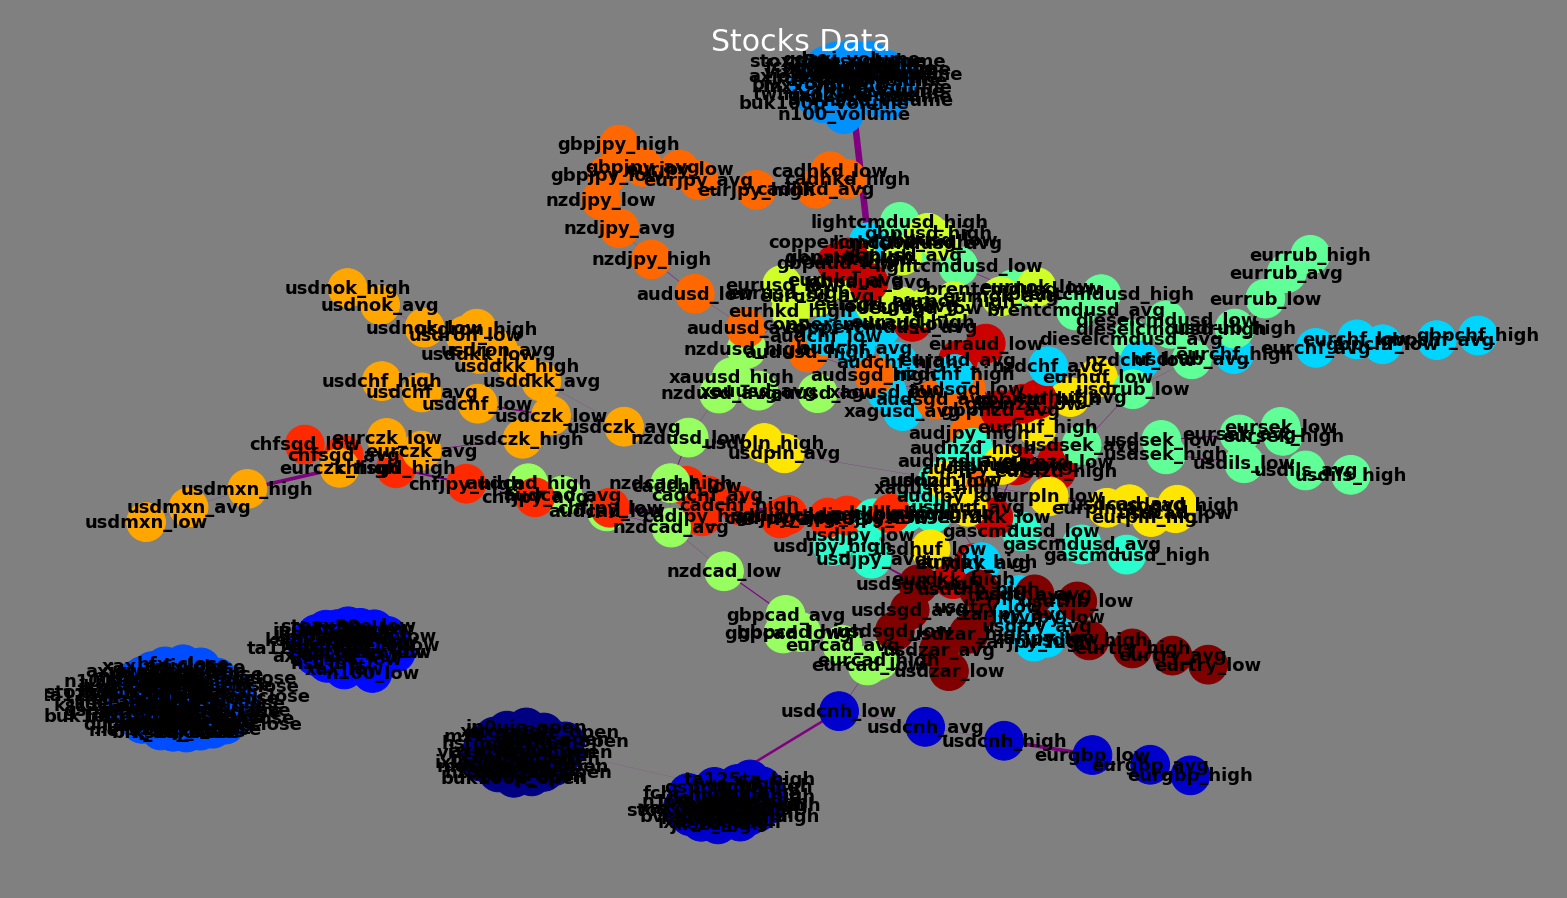

In [17]:
#### This cell implements the louvain algorithm
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]
fig = plt.figure(figsize=(21,12), facecolor='g')
edges = G.edges()
# colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
weights_scaled = [(i * 10) -9.8 for i in weights]
nx.draw_spring(G, cmap = plt.get_cmap('jet'),  edge_color='purple', node_color = values, node_size=1500, with_labels=True, width=weights_scaled, font_size=18, font_color='black', font_weight='bold')
fig.set_facecolor("grey")
fig.suptitle(G.name, fontsize=30, color='white')

In [ ]:
# nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)


In [9]:
G.name

'Stocks Data'

In [8]:
G = graphinate(aggregateframe, "Stocks Data")

Text(0.5,1,'Stocks Data')

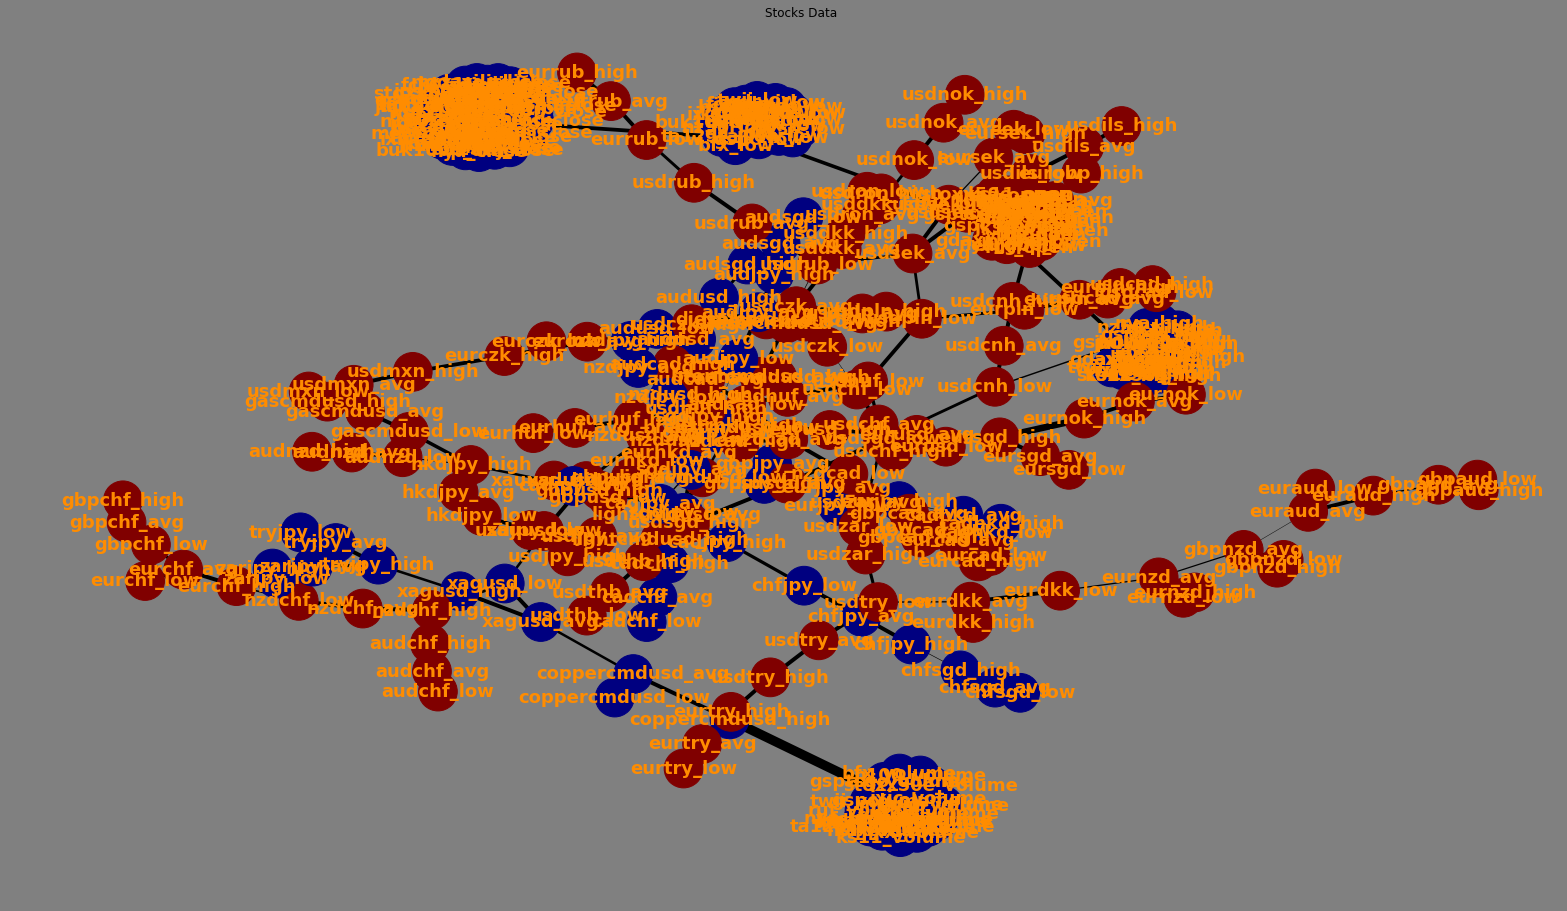

In [10]:
####### This Cell Partitions data using the Kernighan - Lin bisection 
part = nx.algorithms.community.kernighan_lin.kernighan_lin_bisection(G, partition=None, max_iter=10, weight='weight', seed=None)

part = convert_tuple(part)
values = [part.get(node) for node in G.nodes()]
# Specify facecolor when creating the figure

# nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
fig = plt.figure(figsize=(21,12), facecolor='g')
edges = G.edges()
# colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
weights_scaled = [(i * 20) -16 for i in weights]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=1500, with_labels=True, width=weights_scaled, font_size=18, font_color='darkorange', font_weight='bold')
fig.set_facecolor("grey")


In [ ]:
part

In [ ]:
#### This cell creates a dendrogram hierarchy
dendo = community.generate_dendrogram(G)
for level in range(len(dendo) - 1) :
#     print("partition at level", level, "is", community.partition_at_level(dendo, level))
    fig = plt.figure(figsize=(21,12), facecolor='g')
    edges = G.edges()
    # colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    weights_scaled = [(i * 20) -16 for i in weights]
    nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=1500, with_labels=True, width=weights_scaled, font_size=18, font_color='black', font_weight='bold')
    fig.set_facecolor("grey")

In [ ]:
G = graphinate(coinnage, "Data")

In [ ]:

#### This cell creates partitions by girvan_newman #####

from networkx.algorithms import community as newComms
communities_generator = newComms.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted_community = sorted(map(sorted, next_level_communities))

part = convert_sort(sorted_community)
values = [part.get(node) for node in G.nodes()]
fig = plt.figure(figsize=(21,12))
edges = G.edges()
# colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
weights_scaled = [(i * 20) -16 for i in weights]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), edge_color='w', node_color = values, node_size=1500, with_labels=True, width=weights_scaled, font_size=18, font_color='darkorange', font_weight='bold')
fig.set_facecolor("grey")

In [296]:
G = graphinate(highCoins, "Data")

In [ ]:
#### This Cell implements Clauset-Newman-Moore greedy modularity maximization
part = newComms.greedy_modularity_communities(G)
part = convert_sort(part)
values = [part.get(node) for node in G.nodes()]
fig = plt.figure(figsize=(21,12))

edges = G.edges()
# colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
weights_scaled = [(i * 10) -9.8 for i in weights]
nx.draw_spring(G, cmap = plt.get_cmap('jet'),  edge_color='purple', node_color = values, node_size=1500, with_labels=True, width=weights_scaled, font_size=18, font_color='gold', font_weight='bold')
fig.set_facecolor("grey")

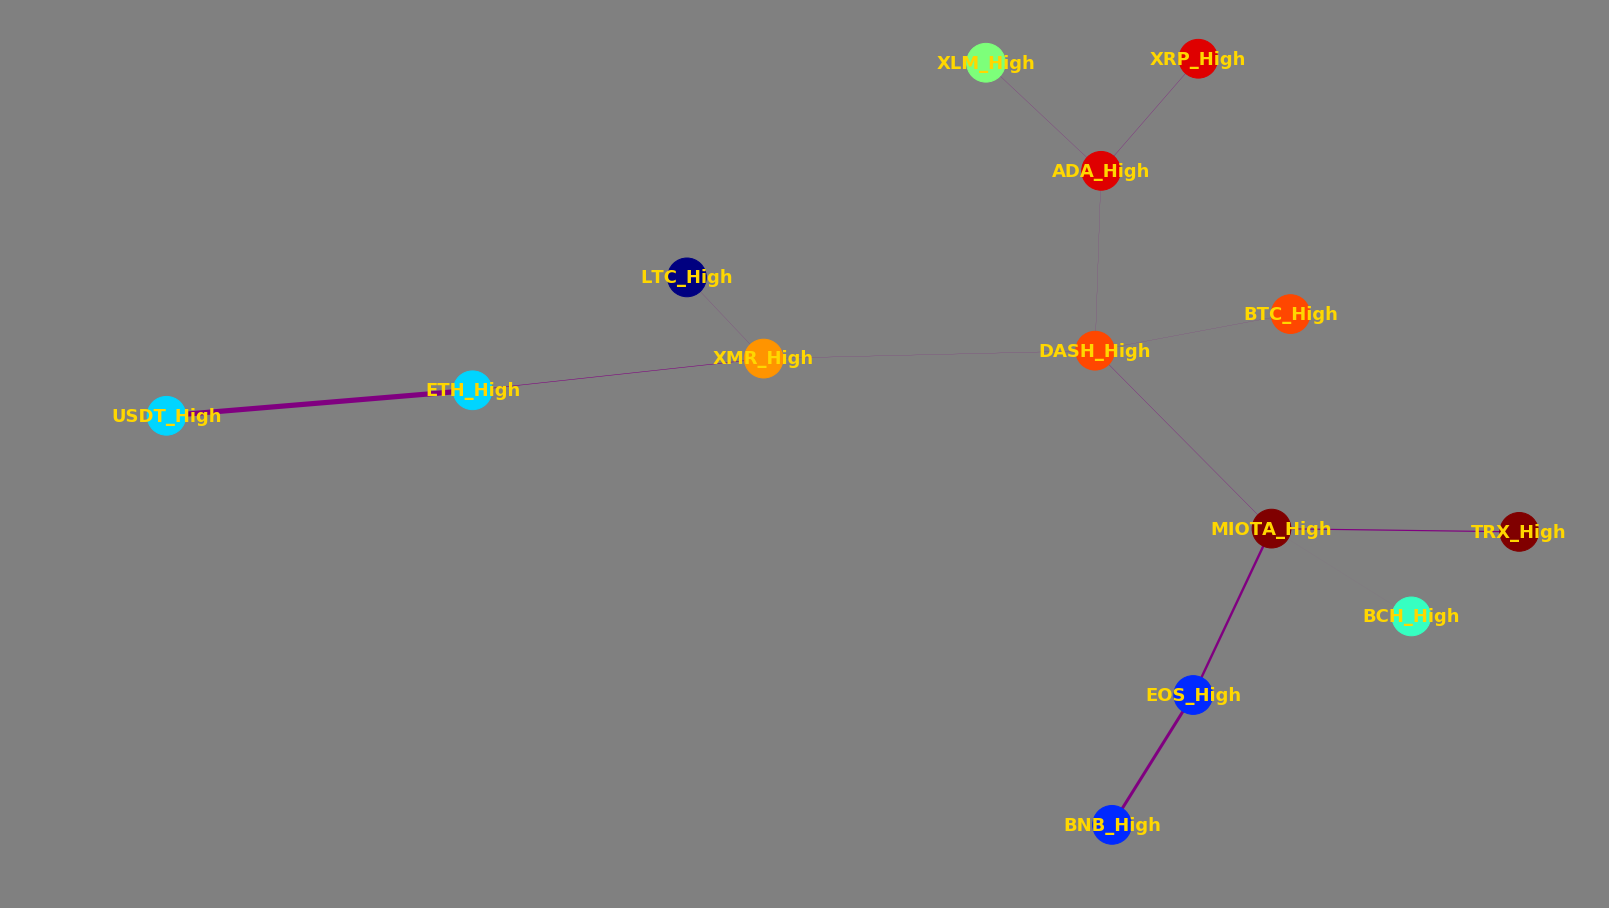

In [297]:
#### This Cell implements some clique based functions
part = list(nx.algorithms.clique.find_cliques(G))
part2 = nx.graph_number_of_cliques(G, cliques=None)
part3  = list(nx.algorithms.clique.enumerate_all_cliques(G))
bipart = nx.algorithms.clique.make_clique_bipartite(G, fpos=None, create_using=None, name=None)
# part = convert_sort(part)
# values = [part.get(node) for node in G.nodes()]

part = convert_sort(part)
values = [part.get(node) for node in G.nodes()]
fig = plt.figure(figsize=(21,12))

edges = G.edges()
# colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
weights_scaled = [(i * 10) -9.8 for i in weights]
nx.draw_spring(G, cmap = plt.get_cmap('jet'),  edge_color='purple', node_color = values, node_size=1500, with_labels=True, width=weights_scaled, font_size=18, font_color='gold', font_weight='bold')
fig.set_facecolor("grey")
